<a href="https://colab.research.google.com/github/whistlebee/pytorch-hosvd/blob/master/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fbpca

In [2]:
!wget https://raw.githubusercontent.com/whistlebee/pytorch-hosvd/master/gpu_hosvd.py

--2019-06-01 04:25:49--  https://raw.githubusercontent.com/whistlebee/pytorch-hosvd/master/gpu_hosvd.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2032 (2.0K) [text/plain]
Saving to: ‘gpu_hosvd.py’

gpu_hosvd.py        100%[===================>]   1.98K  --.-KB/s    in 0s      

2019-06-01 04:25:49 (48.4 MB/s) - ‘gpu_hosvd.py’ saved [2032/2032]



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import face
from gpu_hosvd import gpu_tsvd, gpu_sthosvd
from sklearn.utils.extmath import randomized_svd
from fbpca import pca

Using numpy backend.
Using pytorch backend.
Using pytorch backend.


## gpu_tsvd performance comparison

In [ ]:
def fbsvd(A, k):
    return pca(A, k, raw=True)

algorithms = [
    gpu_tsvd,
    randomized_svd,
    fbsvd
]

dimensions = [50, 100, 200, 500, 700, 1000, 2000, 5000, 7000, 10000, 15000]
num_repeats = 10
timings = np.empty((len(dimensions), len(algorithms), num_repeats))
errors = np.empty((len(dimensions), len(algorithms), num_repeats))

import time

k = 20

for i, d in enumerate(dimensions):
    v = torch.rand(d)
    _a = v.reshape(-1, 1) @ v.reshape(1, -1)
    
    for j, alg in enumerate(algorithms):
        if alg != gpu_tsvd:
            a = _a.detach().cpu().numpy()
        else:
            a = _a
        
        for l in range(num_repeats):
            start = time.time()
            u, s, vt = alg(a, k)
            duration = time.time() - start
            timings[i, j, l] = duration
            try:
                errors[i, j, l] = np.linalg.norm(a - u @ np.diag(s) @ vt) / np.linalg.norm(a)
            except:
                errors[i, j, l] = (torch.norm(a - u @ torch.diag(s) @ vt) / torch.norm(a)).cpu().item()
                
mean_timings = np.mean(timings, axis=2)
mean_errors = np.mean(errors, axis=2)

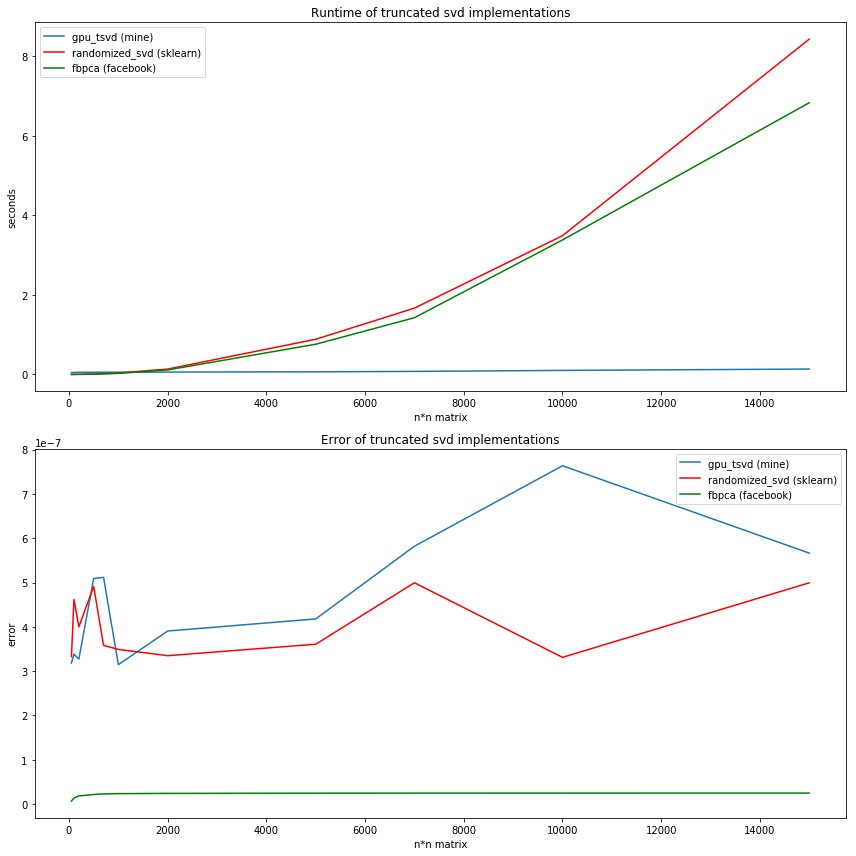

In [5]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

ax = plt.subplot(2, 1, 1)
ax.plot(dimensions, mean_timings[:, 0], label='gpu_tsvd (mine)')
ax.plot(dimensions, mean_timings[:, 1], color='red', label='randomized_svd (sklearn)')
ax.plot(dimensions, mean_timings[:, 2], color='green', label='fbpca (facebook)')
ax.legend()
plt.xlabel('n*n matrix')
plt.ylabel('seconds')
plt.title('Runtime of truncated svd implementations')

ax = plt.subplot(2, 1, 2)
ax.plot(dimensions, mean_errors[:, 0], label='gpu_tsvd (mine)')
ax.plot(dimensions, mean_errors[:, 1], color='red', label='randomized_svd (sklearn)')
ax.plot(dimensions, mean_errors[:, 2], color='green', label='fbpca (facebook)')
ax.legend()
plt.xlabel('n*n matrix')
plt.ylabel('error')
plt.title('Error of truncated svd implementations')

plt.tight_layout()
plt.savefig('comparison.png')

## Image Compression example

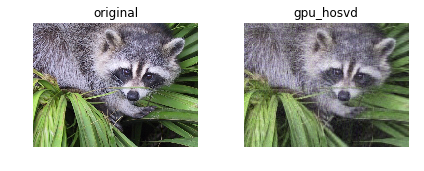

In [6]:
image = tl.tensor(face()).to(0)

def to_image(tensor):
    """A convenience function to convert from a float dtype back to uint8"""
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

core_size = (50, 50, 3)
core, singular_vectors, singular_values = gpu_sthosvd(image, core_size)
tucker_reconstruction = tl.tucker_to_tensor(core, singular_vectors)
tucker_reconstruction = tucker_reconstruction.cpu()

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.imshow(to_image(image))
ax.set_title('original')

ax = fig.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.imshow(to_image(tucker_reconstruction))
ax.set_title('gpu_hosvd')

plt.tight_layout()
plt.show()

In [7]:
compressed_size = sum(np.product(v.shape) for v in singular_vectors) + np.product(core_size)
compression_ratio = (compressed_size / np.product(image.shape)) * 100
print('Compression ratio {:.5f}%'.format(compression_ratio))

Compression ratio 4.11602%
